In [1]:
# %pip install micrograd

In [2]:
# from micrograd.engine import Value

# a = Value(-4.0)
# b = Value(2.0)

# c = a**3 + b**2
# d = c + c
# d  += a + b
# e = d + d.relu()
# print(e, e.data, e.grad)
# e.backward()
# print(e, e.data, e.grad)

# print(a, a.data, a.grad)

In [3]:
# first = Value(20.0)
# second = first + first**2
# thrid = first + second.relu()
# thrid.backward()
# 
# print(first, first.data, first.grad)

## Using the to find simple derivative of a function

In [4]:
# %pip install matplotlib

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

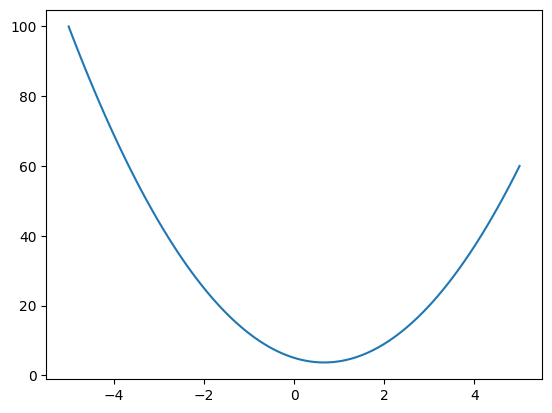

In [7]:
xs = np.linspace(-5, 5, 100)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
h = 0.000001
x = 2/3
df = (f(x+h) - f(x))/h
df

2.999378523327323e-06

In [9]:
a = 2.0
b = -3.0
c = 1.0
d = b**3 - 4*a*c
print(d)

-35.0


In [10]:
class Value:    
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward() -> None:
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(data = self.data * other.data, _children=(self, other), _op='*')
        
        def _backward() -> None:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(data = math.tanh(self.data), _children=(self,), _op='tanh')
        
        def _backward() -> None:
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self) -> None:
        topo = []
        visited = set()
        
        def build_topo(v: Value) -> None:
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [11]:
a = Value(3.0)
b = Value(4.0)
c = a * b
d = c + a
f = Value(-2.0)
L = d * f
L

Value(data=-30.0, grad=0.0)

In [12]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\rishi\anaconda3\Lib\site-packages\graphviz'

In [13]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [14]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [15]:
draw_dot(L)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [21]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-43.3011


In [22]:
print(L)

Value(data=-43.3011, grad=0.0)


In [23]:
L.backward()

In [24]:
print(a.grad, b.grad, c.grad, f.grad)

-32.458 -22.53 -3.85 38.406
